In [7]:
import numpy as np
import nibabel as nib
import dsiadapt as dsi
import dipy.core.gradients as grad
import matplotlib 

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}
matplotlib.rc('font', **font)

%pylab inline
np.set_printoptions(threshold=numpy.nan)

Populating the interactive namespace from numpy and matplotlib


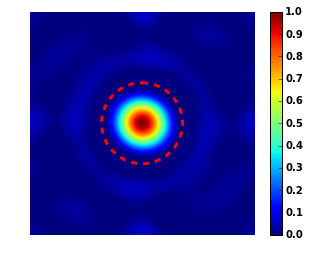

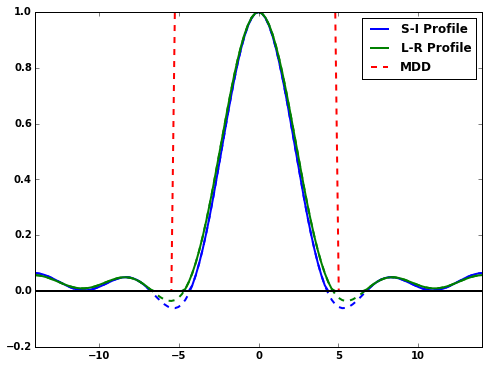

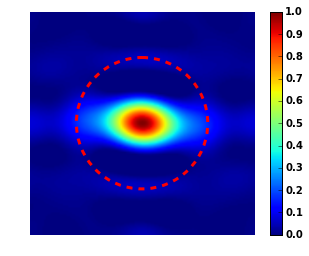

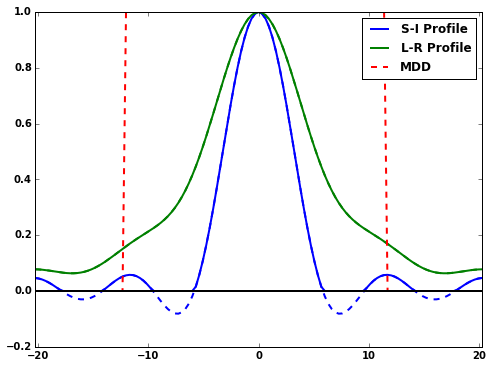

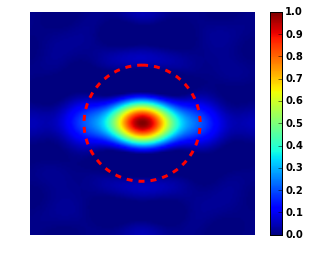

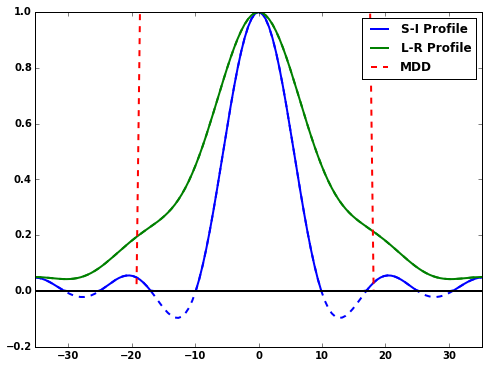

In [8]:
# Compute PDF and plot cross sections and profiles
fnArr = np.array(['DSI11_exvivo', 'DSI11_invivo_b10k', 'DSI11_invivo_b7k'])

qgridsz = 129; # Q-space grid size
qgridcenter = qgridsz//2;
winwidth = np.inf;

for ii in np.arange(fnArr.shape[0]):
    fn = fnArr[ii];
    data = nib.load('data/' + fn + '_cc.nii.gz').get_data();
    gtab = grad.gradient_table('data/' + fn + '_bvals.txt', 'data/' + fn + '_bvecs_dipy.txt');
    
    mdd = np.loadtxt('data/' + fn + '_stats.txt')[0];
    fov = np.loadtxt('data/' + fn + '_stats.txt')[1];
    rend = mdd / fov * qgridsz;
    
    dsimodel = dsi.DiffusionSpectrumModel(gtab, qgrid_size=qgridsz, filter_width=winwidth, r_start=0, r_end=rend, r_step=0.2);
    dsifit = dsimodel.fit(data);
    pdf = dsifit.pdf(normalized=False, clipped=False); 
    
    pdfvox = pdf[2, 0, 0] # Show one voxel
    pdfvox = pdfvox / pdfvox.max()
    
    pdfslice = np.fliplr(np.rot90(pdfvox[:, qgridcenter, :]))
    pdfslice_clipped = np.clip(pdfslice, 0, pdfslice.max())
    
    pdfprofile_v = pdfslice[:, qgridcenter]
    pdfprofile_v_clipped = np.clip(pdfprofile_v, 0, pdfslice.max())
    
    pdfprofile_h = pdfslice[qgridcenter, :]
    pdfprofile_h_clipped = np.clip(pdfprofile_h, 0, pdfslice.max())
    
    # Plot pdf slice
    figure();
    imshow(pdfslice_clipped);
    circle = Circle((qgridsz//2, qgridsz//2), radius = rend, color = 'r', fill=False, linestyle = 'dashed', linewidth=3.)
    gca().add_artist(circle)
    axis('off');
    colorbar();
    savename = 'figure2/' + fn + '_pdfslice.png';
    savefig(savename, dpi = 600)
    
    # Plot pdf profile
    fig = figure();
    fig.set_size_inches([8, 6])
    
    x = np.linspace(-fov / 2., fov / 2., num = qgridsz) # Unit: mm
    xvis = x * 10**3; # Unit: um. Use xvis for visualization
    
    mddrect = np.zeros(xvis.shape);
    mddrect[qgridsz//2 - rend : qgridsz//2 + rend] = 1;
    
    plot(xvis, pdfprofile_v_clipped, 'b', linewidth=2, label='S-I Profile')
    plot(xvis, pdfprofile_v, 'b--', linewidth=2)
    plot(xvis, pdfprofile_h_clipped, 'g', linewidth=2, label='L-R Profile')
    plot(xvis, pdfprofile_h, 'g--', linewidth=2)
    plot(xvis, mddrect, 'r--', linewidth=2, label='MDD')
    plot(xvis, np.zeros(xvis.shape), 'k', linewidth=2)
        
    xlim(xvis.min(), xvis.max())
    legend()
    savename = 'figure2/' + fn + '_pdfprofile.png';
    savefig(savename, dpi = 600)
    